In [1]:

import os
import librosa
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import kagglehub

# Download dataset
AUDIO_PATH = kagglehub.dataset_download("afisarsy/raw-audio-of-accident-and-crime-detection")
print("Path to dataset files:", AUDIO_PATH)

100%|██████████| 573M/573M [00:19<00:00, 30.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/afisarsy/raw-audio-of-accident-and-crime-detection/versions/1


In [2]:
# Constants
MAX_LEN = 40
SAMPLE_RATE = 22050
N_MFCC = 13

# Feature extraction function
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC).T
        if mfcc.shape[0] < MAX_LEN:
            mfcc = np.pad(mfcc, ((0, MAX_LEN - mfcc.shape[0]), (0, 0)), mode='constant')
        else:
            mfcc = mfcc[:MAX_LEN]
        return mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


In [3]:
# Load data
features = []
labels = []
for root, dirs, files in os.walk(AUDIO_PATH):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)
            label = os.path.basename(root)
            mfcc = extract_features(file_path)
            features.append(mfcc)
            labels.append(label)



X = np.array(features)
y = np.array(labels)


In [4]:
# Label encoding
le = LabelEncoder()
y_encoded = tf.keras.utils.to_categorical(le.fit_transform(y))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print(f"Data loaded. Shape: {X.shape}, Classes: {le.classes_}")

# Model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(MAX_LEN, N_MFCC)),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(y_encoded.shape[1], activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test))


Data loaded. Shape: (1678, 40, 13), Classes: ['car_crash' 'conversation' 'engine_idling' 'gun_shot' 'jambret' 'maling'
 'rain' 'rampok' 'road_traffic' 'scream' 'thunderstorm' 'tolong' 'wind']
Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.2701 - loss: 2.1739 - val_accuracy: 0.7024 - val_loss: 1.0476
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.7137 - loss: 0.8843 - val_accuracy: 0.7589 - val_loss: 0.7761
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7886 - loss: 0.6252 - val_accuracy: 0.8214 - val_loss: 0.5741
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8245 - loss: 0.4988 - val_accuracy: 0.8333 - val_loss: 0.5794
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8481 - loss: 0.4350 - val_accuracy: 0.8661 - val_loss: 0.4922
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8947 - loss: 0.3387 - val_accuracy: 0.8601 - val_loss: 0.5264
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/

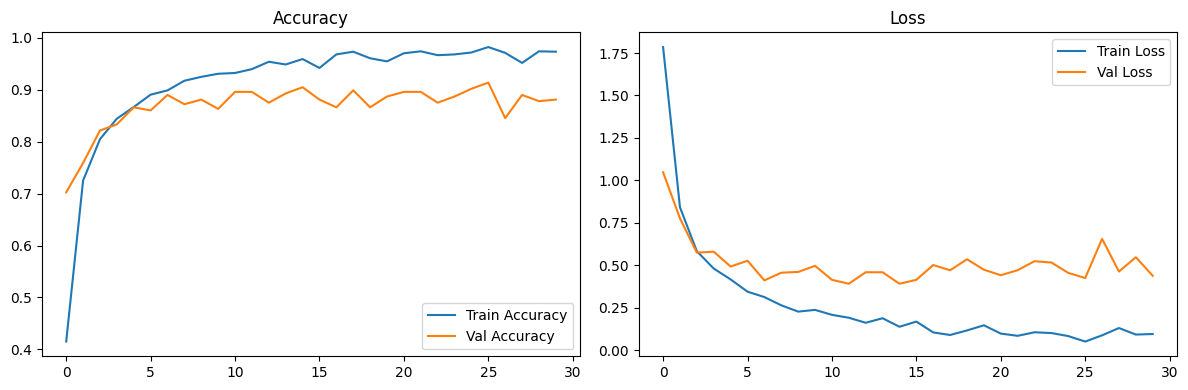

In [5]:
# Accuracy and loss plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy")
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.tight_layout()
plt.show()

In [6]:
# Classification report
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred, target_names=le.classes_))

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
               precision    recall  f1-score   support

    car_crash       0.60      0.75      0.67        16
 conversation       0.89      1.00      0.94        17
engine_idling       0.89      0.73      0.80        11
     gun_shot       0.90      0.84      0.87        45
      jambret       0.97      0.97      0.97        35
       maling       1.00      0.97      0.98        29
         rain       0.76      0.84      0.80        19
       rampok       0.85      0.96      0.90        23
 road_traffic       0.85      0.96      0.90        24
       scream       0.93      0.84      0.88        31
 thunderstorm       0.83      0.69      0.75        29
       tolong       0.97      0.95      0.96        37
         wind       0.81      0.85      0.83        20

     accuracy                           0.88       336
    macro avg       0.87      0.87      0.87       336
 weighted avg       0.89      0.88      0.88       336



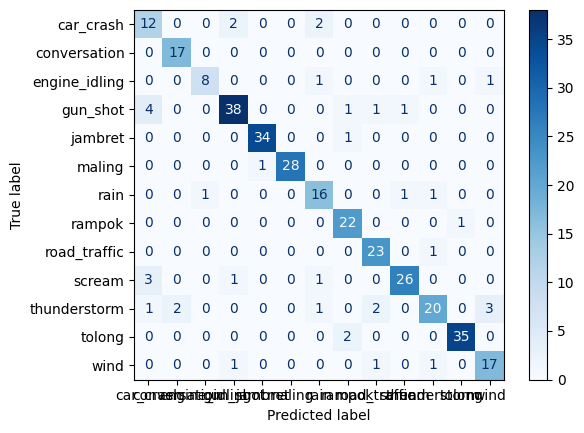

In [7]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [8]:
!pip install librosa resampy numpy
!pip install librosa resampy numpy scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 24.6 MB/s eta 0:00:00


In [9]:
import librosa
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from google.colab import files
import os

In [10]:
def extract_features(file_path):
    try:
        audio, sample_rate = librosa.load(file_path, sr=22050, duration=4.0)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
        if mfccs.shape[1] < 40:
            pad_width = 40 - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :40]
        return mfccs.T
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return None

In [11]:
# Step 5: Prediction function
def predict_gender(audio_file_path):
    mfccs = extract_features(audio_file_path)
    if mfccs is not None:
        mfccs = np.expand_dims(mfccs, axis=0)
        prediction = model.predict(mfccs)
        predicted_class = np.argmax(prediction)
        predicted_label = le.inverse_transform([predicted_class])[0]
        return predicted_label
    else:
        return "Error extracting features."

Saving 133797-6-2.wav to 133797-6-2.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted Accident or crime 133797-6-2.wav: gun_shot


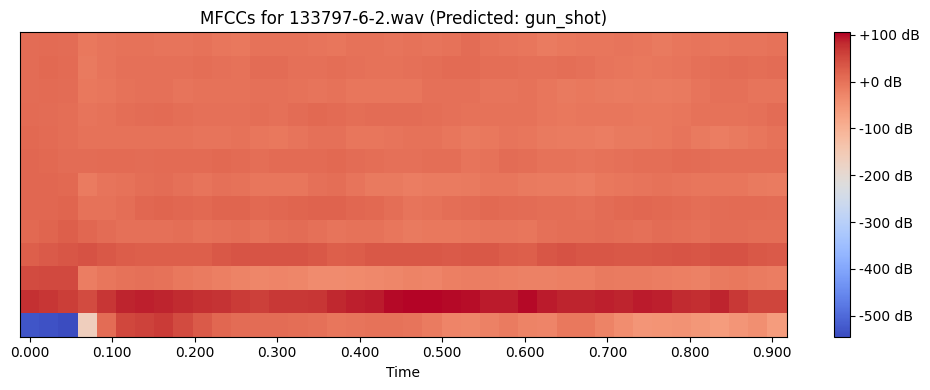

In [12]:

import IPython.display as ipd
uploaded = files.upload()

for fn in uploaded.keys():
    audio_file_path = fn
    predicteds_sound = predict_gender(audio_file_path)
    print(f"Predicted Accident or crime {audio_file_path}: {predicteds_sound}")

    mfccs = extract_features(audio_file_path)

    if mfccs is not None:
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mfccs.T, sr=SAMPLE_RATE, x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'MFCCs for {audio_file_path} (Predicted: {predicteds_sound})')
        plt.tight_layout()
        plt.show()

ipd.Audio(audio_file_path)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


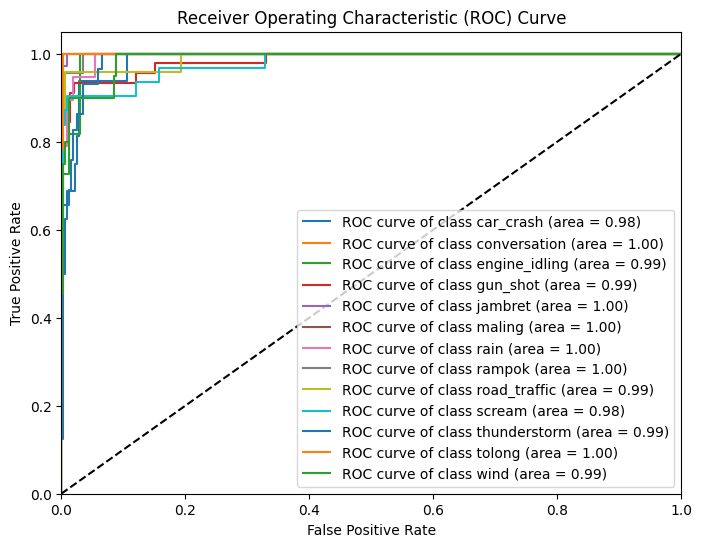

In [14]:
# prompt: ROC Curve of my model

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_pred contains probabilities for each class
y_pred_prob = model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {le.classes_[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
